# Set Up and libraries

In [1]:
# Reviews CSV
%%capture
#!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=mexudbu2&dl=0
#!mv Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv
# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=fqh0067i&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv

!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv

In [2]:
!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=tqfdpqjv&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv

--2024-12-04 05:10:02--  https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc690ac8179f7d8468444a8367a1.dl.dropboxusercontent.com/cd/0/inline/CfkapJFgXgiVCiDaf0HXF6-wTQN7RiGG2cFDKqGjem4ZAR9fJBmbw1Rwtn2AIKwEiQRoEQLUB_VvYxb5dlx58fkd9ZWkRxzm9hnqv5ojrWTWeCnXXDKUtPZS1Yf-_2EswY6Hv2G-Rj1MO6wrPBdwXyCD/file# [following]
--2024-12-04 05:10:03--  https://uc690ac8179f7d8468444a8367a1.dl.dropboxusercontent.com/cd/0/inline/CfkapJFgXgiVCiDaf0HXF6-wTQN7RiGG2cFDKqGjem4ZAR9fJBmbw1Rwtn2AIKwEiQRoEQLUB_VvYxb5dlx58fkd9ZWkRxzm9hnqv5ojrWTWeCnXXDKUtPZS1Yf-_2EswY6Hv2G-Rj1MO6wrPBdwXyCD/file
Resolving uc690ac8179f7d8468444a8367a1.dl.dropboxusercontent.com (uc690ac8179f7d8468444a8367a1.dl.dropboxusercontent.com)... 162.125.2.15, 262

In [3]:
!wget https://www.dropbox.com/scl/fi/rd8xxbz8duqp7s3nkzylv/imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2&st=9mn8cev0&dl=0
!mv imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2 imgs_features.npy

--2024-12-04 05:10:03--  https://www.dropbox.com/scl/fi/rd8xxbz8duqp7s3nkzylv/imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdff8be3d2522af4aa6501d553.dl.dropboxusercontent.com/cd/0/inline/CfnoUZlwh40qKLtwptfYNC0jKUhbZ4DM56R9RkqXJXzmp8LFynJ0W4x3G8Rgq7wMITak740Wz1treMxeIGWsVidy0VFnyA0fd9J8wQ3PzQkaNOWBRa2ybYIZwD5lNJN-BPmaNOPdr5mceGIyXb84i4oC/file# [following]
--2024-12-04 05:10:04--  https://uccdff8be3d2522af4aa6501d553.dl.dropboxusercontent.com/cd/0/inline/CfnoUZlwh40qKLtwptfYNC0jKUhbZ4DM56R9RkqXJXzmp8LFynJ0W4x3G8Rgq7wMITak740Wz1treMxeIGWsVidy0VFnyA0fd9J8wQ3PzQkaNOWBRa2ybYIZwD5lNJN-BPmaNOPdr5mceGIyXb84i4oC/file
Resolving uccdff8be3d2522af4aa6501d553.dl.dropboxusercontent.com (uccdff8be3d2522af4aa6501d553.dl.dropboxusercontent.com)... 162.125.2.15, 2

In [4]:
%%capture
!pip install psutil
import time
import psutil

In [5]:
!pip install cornac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.3 MB/s eta 0:00:00


In [6]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time

import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer

from concurrent.futures import ThreadPoolExecutor

In [7]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch


In [8]:
from tqdm import tqdm

In [9]:
from collections import Counter

# Data Preprocessing

In [10]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [11]:
X = df[['user_id', 'rest_id', 'rating']]


restaurants = pd.read_csv('/content/restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

<ipython-input-11-e554682ed1a9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categ_id'] = X_categories


In [12]:
X.head()

,user_id,rest_id,rating,categ_id
0,114453580163034019886,3818,5,0
1,103598690263545033047,3819,5,262
2,115640749244801394506,3820,5,8
3,104421748665385525393,3822,5,0
4,108976745273958544598,3823,4,143


In [13]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [14]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [15]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [16]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

In [17]:
userset = set(X['user_id'].tolist())
itemset = restaurants_dict.keys()
user_to_idx = {user: idx for idx, user in enumerate(userset)}
item_to_idx = {item: idx for idx, item in enumerate(itemset)}

idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

In [18]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))
print(len(user_reviews.keys()))

7254


In [19]:
x_train, x_test = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        x_train.extend([(user, review) for review in reviews])  # Agregar user a cada review en train_set
    else:
        if 1 < len(reviews) <= 3:
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)

        x_train.extend([(user, review) for review in train_data])  # Agregar user a cada review en train_set
        x_test.extend([(user, review) for review in test_data])  # Agregar user a cada review en test_set

In [20]:
x_train = list(map(lambda x: (x[0], *x[1]), x_train))
x_test = list(map(lambda x: (x[0], *x[1]), x_test))

In [21]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [22]:
x_train[:10]

[('114453580163034019886', 0, 3818, 5, 0),
 ('103598690263545033047', 1, 3819, 5, 262),
 ('115640749244801394506', 2, 3820, 5, 8),
 ('104421748665385525393', 3, 3822, 5, 0),
 ('108976745273958544598', 4, 3823, 4, 143),
 ('108973466903602523839', 5, 3824, 5, 105),
 ('109475182895538391100', 6, 3826, 5, 0),
 ('105706087522063800752', 7, 3827, 5, 1425),
 ('106467390376527978618', 8, 3830, 4, 0),
 ('110016946739014503360', 9, 3831, 5, 1427)]

In [23]:
# (review ID, restaurant ID, review's rating, restaurant categories ID)
X_train = pd.DataFrame(x_train, columns=['user_id', 'review_id', 'rest_id', 'rating', 'categ_id'])
X_test = pd.DataFrame(x_test, columns=['user_id', 'review_id', 'rest_id', 'rating', 'categ_id'])



In [24]:
X_train.head()

,user_id,review_id,rest_id,rating,categ_id
0,114453580163034019886,0,3818,5,0
1,103598690263545033047,1,3819,5,262
2,115640749244801394506,2,3820,5,8
3,104421748665385525393,3,3822,5,0
4,108976745273958544598,4,3823,4,143


In [25]:
X_train.to_csv('reviews_train.csv', index=False)
X_test.to_csv('reviews_test.csv', index=False)

In [26]:
print('Train size: ', X_train.shape[0] * 100 / (X.shape[0]))
print('Test size: ', X_test.shape[0] * 100 / (X.shape[0]))

Train size:  90.4205026125902
Test size:  9.579497387409804


# Utils

In [34]:
X_train.head()

,user_id,review_id,rest_id,rating,categ_id
0,114453580163034019886,0,3818,5,0
1,103598690263545033047,1,3819,5,262
2,115640749244801394506,2,3820,5,8
3,104421748665385525393,3,3822,5,0
4,108976745273958544598,4,3823,4,143


In [35]:
user_items_train = {}
itemset = set()

for row in X_train.itertuples():
    if row[1] not in user_items_train:
        user_items_train[row[1]] = []

    user_items_train[row[1]].append(row[3])
    itemset.add(row[3])


itemset = np.sort(list(itemset))


user_items_test = {}

for row in X_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[3])

In [36]:
# reciprocal rank
def rr(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0


In [37]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if index not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df


In [38]:
def get_relevant_items(user):
    relevant_items = list(
        map(lambda x: x[2],
        filter(lambda x: x[3] >= 3.5,
        filter(lambda x: x[0] == user, x_test)
    )))
    return relevant_items

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users



def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users



def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in user_items_test.keys():
        reclist = model_reclist.get(u)
        if reclist is None: continue
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += rr(reclist, user_reviews)


    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_recall /= len(user_items_test)
    mean_precission /= len(user_items_test)
    mean_rr /= len(user_items_test)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')



# Models

## Most popular

In [ ]:
X_train.head()

,user_id,review_id,rest_id,rating,categ_id
0,114453580163034019886,0,3818,5,0
1,103598690263545033047,1,3819,5,262
2,115640749244801394506,2,3820,5,8
3,104421748665385525393,3,3822,5,0
4,108976745273958544598,4,3823,4,143


In [ ]:
USER_COL = 0
ITEM_COL = 2
RATING_COL = 3

In [ ]:
model_mp = pyreclab.MostPopular(
    dataset= 'reviews_train.csv',
    header = True,
    usercol = USER_COL,
    itemcol = ITEM_COL,
    ratingcol = RATING_COL
)

In [ ]:
model_mp.train(progress=True)

In [ ]:
mp_reclist10, mp_map10, mp_ndcg10 = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = USER_COL,
    itemcol = ITEM_COL,
    ratingcol = RATING_COL,
    topn = 10,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

mp_reclist20, mp_map20, mp_ndcg20 = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = USER_COL,
    itemcol = ITEM_COL,
    ratingcol = RATING_COL,
    topn = 20,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

### Ejemplo

In [ ]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if str(index) not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df

In [ ]:
random_user = '100012107238749468669'

In [ ]:
show_recommendations(
    random_user,                # Random user ...
    mp_reclist10[random_user]
)

,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
4,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
5,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
6,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
7,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...
8,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
9,Burger King,Well-known fast-food chain serving grilled bur...,Restaurant;Fast food restaurant


In [ ]:
show_recommendations(
    random_user,                # Random user ...
    mp_reclist20[random_user]
)

,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
4,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
5,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
6,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
7,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
8,Cold Stone Creamery,Ice cream chain offering design-your-own creat...,Frozen yogurt shop;Ice cream shop;Dessert rest...
9,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...


### Metricas

In [ ]:
evaluate_model(mp_reclist10, n=10)

MAP@10: 0.008844765342960286
nDCG@10: 0.07008514432929244
Recall@10: 0.0687725631768953
Precision@10: 0.008664259927797832
MRR@10: 0.0323756518251103
Novelty@10: 5.361293814662297
Diversity@10: 1.0


In [ ]:
evaluate_model(mp_reclist20, n=20)

MAP@20: 0.005234657039711188
nDCG@20: 0.08261485776279132
Recall@20: 0.08086642599277978
Precision@20: 0.005144404332129961
MRR@20: 0.033319254344921875
Novelty@20: 5.735274772920034
Diversity@20: 1.0


## Random

In [ ]:
random_reclist10 = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['rest_id'].to_list(), k=10))
    random_reclist10[user_id] = list([str(x) for x in reclist])

In [ ]:
random_reclist20 = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['rest_id'].to_list(), k=20))
    random_reclist20[user_id] = list([str(x) for x in reclist])

### Ejemplo

In [ ]:
show_recommendations(random_user, random_reclist10[random_user])

,name,description,categories
0,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
1,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
2,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...
3,Campesino Cafe,NaN,Mexican restaurant
4,The Garden at Palafox + Main,NaN,Food court;Restaurant;Shopping mall
5,Sonic Drive-In,Fast-food burger & fries joint with an old-sch...,Fast food restaurant;Hamburger restaurant;Chic...
6,La Palmita,NaN,Mexican restaurant
7,Chanello's Pizza,No-frills regional take-out/delivery chain off...,Sandwich shop;Pizza delivery;Pizza Takeout;Chi...
8,Shirlington halal pizza,NaN,Delivery Restaurant;Pizza restaurant
9,Larry's Italian Restaurant,NaN,Italian restaurant


In [ ]:
show_recommendations(random_user, random_reclist20[random_user])

,name,description,categories
0,Thanh Thai Restaurant,NaN,Vietnamese restaurant
1,Tanglad,NaN,Vietnamese restaurant
2,Curry Kitchen,NaN,Indian takeaway;Modern Indian restaurant;Fast ...
3,Chili Pot,Compact Chinese eatery serving hot pots & othe...,Barbecue restaurant;Chinese restaurant;Sichuan...
4,Pinecrest Pizzeria - North Miami,NaN,Italian restaurant;Pizza delivery;Pizza Takeou...
5,Spice Boys Kitchen,NaN,Service establishment;Delivery Restaurant
6,Seoul Station,NaN,Korean restaurant
7,Tetsumen Ramen,NaN,Japanese restaurant
8,The Green Pig food truck,NaN,Fast food restaurant
9,Giovanni's Aloha Shrimp,Mainstay eatery for boiled shrimp in garlic sa...,Seafood restaurant;Fast food restaurant


### Metricas

In [ ]:
evaluate_model(random_reclist10, n=10)


MAP@10: 0.0007220216606498196
nDCG@10: 0.004614499837312906
Recall@10: 0.004873646209386282
Precision@10: 0.0007220216606498196
MRR@10: 0.004392298435619736
Novelty@10: 8.485870172117659
Diversity@10: 0.8125451263537902


In [ ]:
evaluate_model(random_reclist20, n=20)

MAP@20: 0.000631768953068592
nDCG@20: 0.010368866913858845
Recall@20: 0.009386281588447653
Precision@20: 0.0005415162454873646
MRR@20: 0.001133509962348357
Novelty@20: 8.497199621412424
Diversity@20: 0.7997234361475296


## Multimodal Recsys (Cornac Library)

In [ ]:
# * Codigo obtenido del practico 4 *

modelo_escogido = 'vgg19' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
imgs_model_width, imgs_model_height = 224, 224

In [32]:
df_sample = df

In [33]:
print(df_sample.value_counts('rating'))
print(df_sample.shape)

rating
5    5280
4    1564
3     496
1     436
2     262
Name: count, dtype: int64
(8038, 9)


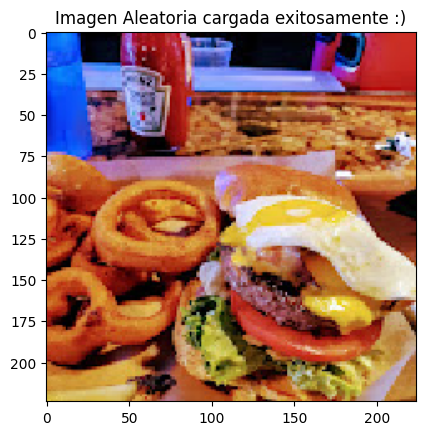

In [36]:
FOLDER = 'reviews'
files = df_sample['img_filename'].tolist()
idx =  random.randint(0, len(files))
original = load_img(f'{FOLDER}/{files[idx]}', target_size=(imgs_model_width, imgs_model_height))
plt.title("Imagen Aleatoria cargada exitosamente :)")
plt.imshow(original)
plt.show()


In [39]:
D_IE = 0 # Download Images Embeddings

In [40]:
# En una lista iremos guardando cada imagen preprocesada
if D_IE:
    all_images = []
    for f in files_sample:
        prefix = FOLDER
        filename = f'{prefix}/{f}'
        original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)

        all_images.append(image_batch)

    images = np.vstack(all_images)

    processed_imgs = preprocess_input(images.copy()) # preprocesamos todas las imagenes
    imgs_features = feat_extractor.predict(processed_imgs)
    print("features extraidos exitosamente! :)")
    print(imgs_features.shape)
    with open('imgs_features_1.npy', 'wb') as file: # guardamos los embeddings
        np.save(file, imgs_features)
else:
    with open('imgs_features.npy', 'rb') as file:
        imgs_features = np.load(file)

In [41]:
# Text modality configurations
VOCAB_SIZE = 5000
item_text_modality = TextModality(
    corpus=df_sample['text'].tolist(),
    id_map=item_to_idx,
    max_vocab=VOCAB_SIZE,
    tokenizer=BaseTokenizer()
)



In [42]:
# Images configurations
item_image_modality = ImageModality(
    features=imgs_features,
    ids=item_to_idx
    )

In [43]:
uir_list = X[['user_id', 'rest_id', 'rating']].values.tolist()

In [44]:
SEED = 42
VERBOSE = True
USE_GPU = torch.cuda.is_available()


In [45]:
X_test.shape[0] / (X.shape[0])

0.09579497387409804

In [55]:
ratio_split = RatioSplit(
    data=uir_list,
    test_size=0.095,
    rating_threshold=3.5,
    item_text=item_text_modality, # agregamos la modalidad de texto
    item_image=item_image_modality, # agregamos la modalidad de imagen
    seed=SEED,
    verbose=VERBOSE,
)

rating_threshold = 3.5
exclude_unknowns = True
---
Training data:
Number of users = 6605
Number of items = 6187
Number of ratings = 7270
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 6605
Number of items = 6187
Number of ratings = 36
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6605
Total items = 6187


In [48]:
imgs_features.shape

(8038, 4096)

## Training

In [56]:
# modelo CDL (Collaborative Deep Learning)
cdl = cornac.models.CDL(
    k=50, # dimension factor latente
    autoencoder_structure=[200],  # N° de neuronas de la capa code/decoder para SDAE
    vocab_size=VOCAB_SIZE, # cantidad maxima de vocabulario
    act_fn='tanh',
    max_iter=20,
    batch_size=1024,
    seed=SEED,
    verbose=VERBOSE
)
# modelo VBPR (Visual Bayesian Personalized Ranking)
vbpr = cornac.models.VBPR(
    k=10, # dimension de gamma en el espacio latente
    k2=40,  # dimension de theta en el espacio latente
    n_epochs=20,
    use_gpu=USE_GPU,
    batch_size=1024,
    seed=SEED,
    verbose=VERBOSE
)

In [57]:
def get_metrics(n):
    # numero de n elementos en la lista de recomendacion
    RMSE_n = cornac.metrics.RMSE()
    AUC_n = cornac.metrics.AUC()
    MAP_n = cornac.metrics.MAP()
    MRR_n = cornac.metrics.MRR()

    Recall_n = cornac.metrics.Recall(k=n)
    Precision_n = cornac.metrics.Precision(k=n)
    F1_n = cornac.metrics.FMeasure(k=n)
    nDCG_n = cornac.metrics.NDCG(k=n)
    return [RMSE_n, AUC_n, MAP_n, Recall_n, Precision_n, F1_n, nDCG_n, MRR_n]


## Experiment to recommend 10 restaurants

In [58]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[cdl],
                             metrics=get_metrics(n=10))
text_exp.run()


[CDL] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/36 [00:00<?, ?it/s]

Ranking:   0%|          | 0/36 [00:00<?, ?it/s]


TEST:
...
    |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
CDL | 3.3889 | 0.5674 | 0.0176 | 0.0565 | 0.0562 |  0.0634 |       0.0097 |    0.0968 |   98.6551 |   0.2372



In [59]:
cdl_reclist10 = {}
for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = cdl.recommend(user_id)
        cdl_reclist10[user_id] = recs[:10]
    except ValueError as e:
        continue


In [60]:
len(cdl_reclist10.keys()) / X.shape[0]

0.0687982085095795

In [61]:
cdl_novelty10 = novelty(cdl_reclist10)
cdl_diversity10 = diversity(cdl_reclist10)
print(f'Novelty@{10}: {cdl_novelty10}')
print(f'Diversity@{10}: {cdl_diversity10}')

Novelty@10: 7.244830262459239
Diversity@10: 0.8855334538878814


In [62]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[vbpr],
                             metrics=get_metrics(n=10))
text_exp.run()


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/8 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/36 [00:00<?, ?it/s]

Ranking:   0%|          | 0/36 [00:00<?, ?it/s]


TEST:
...
     |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
VBPR | 2.4026 | 0.5696 | 0.0000 | 0.0014 | 0.0011 |  0.0000 |       0.0000 |    0.0000 |   17.1398 |   0.3488



In [63]:
def get_reclist(id_user, model, n):
    """ funcion que retorna la lista de recomendaciones para un usuario.
    Valido solo para modelos de cornac. """
    scores_for_user = model.score(id_user)
    scores_for_user = [
        (idx_to_item[idx], score) for idx, score in enumerate(scores_for_user)
    ]
    scores_for_user.sort(key=lambda x: x[1], reverse=True)
    return [i[0] for i in scores_for_user[:n]]

In [64]:
vbpr_reclist10 = {}

for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = vbpr.recommend(user_id)
        vbpr_reclist10[user_id] = recs[:10]
    except ValueError as e:
        continue


In [65]:
len(vbpr_reclist10.keys()) / X.shape[0]

0.0687982085095795

In [66]:
vbpr_novelty10 = novelty(vbpr_reclist10)
vbpr_diversity10 = diversity(vbpr_reclist10)
print(f'Novelty@{10}: {vbpr_novelty10}')
print(f'Diversity@{10}: {vbpr_diversity10}')

Novelty@10: 6.823581809559918
Diversity@10: 0.7952983725135624


### Examples

In [67]:
random_user = random.choice(list(idx_to_user.keys()))

In [68]:
show_recommendations(
    random_user,
    get_reclist(random_user, vbpr, 10)
)

,name,description,categories
0,Pestolini,Contemporary all-day coffeehouse with a casual...,Italian restaurant;Restaurant
1,Pagoda House,NaN,Chinese restaurant
2,Planet Smoothie,Sleek chain for custom smoothies made with yog...,Health food restaurant;Juice shop
3,Mr Ceviche Peruvian Restaurant,NaN,Peruvian restaurant;Latin American restaurant
4,Taqueria Remis,NaN,Mexican restaurant
5,Café Kalawe,NaN,Restaurant
6,Scotty's Deli & Catering,NaN,Caterer;Restaurant
7,Samurai | Japanese Cuisine,"Calm restaurant with minimalist, modern decor ...",Asian restaurant;Southeast Asian restaurant;Ja...
8,Su Casa Mexican Grill And Cantina,NaN,Mexican restaurant
9,El Vaquero,NaN,Mexican restaurant


In [69]:
show_recommendations(
    random_user,
    get_reclist(random_user, cdl, 10)
)

,name,description,categories
0,Naan n Curry,NaN,Indian restaurant
1,Burgeon at The Arbor - Little Italy,NaN,Restaurant
2,South Harbor Waterfront,Upscale American food & wine served with a str...,Wine bar;Latin American restaurant;Traditional...
3,WaBa Grill,"Teriyaki bowls with chicken, steak, shrimp & v...",Asian restaurant;Rice restaurant;Health food r...
4,Rock N Pies,NaN,Pizza restaurant
5,Flagship Taproom,NaN,Restaurant;Beer garden
6,Thailand Restaurant Novato,NaN,Restaurant
7,Kozo Sushi Kapahulu,Outpost of an Osaka-based chain serving sushi ...,Asian restaurant;Restaurant;Japanese restauran...
8,On Dong Chinese Restaurant,Simple eatery known for its Chinese-Korean spe...,Chinese restaurant
9,Zoom Zoom #3,NaN,Convenience store;Fast food restaurant


## Experiment to recommend 20 restaurants

In [70]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[cdl, vbpr],
                             metrics=get_metrics(n=20))
text_exp.run()


[CDL] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/36 [00:00<?, ?it/s]

Ranking:   0%|          | 0/36 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/8 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/36 [00:00<?, ?it/s]

Ranking:   0%|          | 0/36 [00:00<?, ?it/s]


TEST:
...
     |   RMSE |    AUC |  F1@20 |    MAP |    MRR | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
CDL  | 3.3889 | 0.5552 | 0.0092 | 0.0563 | 0.0561 |  0.0634 |       0.0048 |    0.0968 |   97.7415 |   0.3263
VBPR | 1.9844 | 0.5619 | 0.0031 | 0.0064 | 0.0065 |  0.0102 |       0.0016 |    0.0323 |   20.5085 |   0.2091



In [71]:
cdl_reclist20 = {}
for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = cdl.recommend(user_id)
        cdl_reclist20[user_id] = recs[:20]
    except ValueError as e:
        continue

In [72]:
cdl_novelty20 = novelty(cdl_reclist20)
cdl_diversity20 = diversity(cdl_reclist20)
print(f'Novelty@{20}: {cdl_novelty10}')
print(f'Diversity@{20}: {cdl_diversity20}')

Novelty@20: 7.244830262459239
Diversity@20: 0.8463833634719714


In [73]:
vbpr_reclist20 = {}
for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = vbpr.recommend(user_id)
        vbpr_reclist20[user_id] = recs[:20]
    except ValueError as e:
        continue

In [74]:
vbpr_novelty20 = novelty(vbpr_reclist20)
vbpr_diversity20 = diversity(vbpr_reclist20)
print(f'Novelty@{20}: {vbpr_novelty20}')
print(f'Diversity@{20}: {vbpr_diversity20}')

Novelty@20: 6.9409525617036
Diversity@20: 0.7833634719710675


# Fuentes:
> [1] Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).

> [2] He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.

Links:

> (1) https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/02_multimodality.ipynb

> (2) https://github.com/PreferredAI/tutorials/tree/master